# Miscellaneous COVID-19 Data Analyses

Data sources: 

- [CDC Provisional Death Counts for Coronavirus Disease](https://www.cdc.gov/nchs/nvss/vsrr/covid19/index.htm)
- [Johns Hopkins University's Center for Systems Science and Engineering (CSSE) COVID-19 data repository](https://github.com/CSSEGISandData/COVID-19)


## Imports and constants

In [2]:
import matplotlib
import matplotlib.pyplot as p
import numpy as np
from datetime import datetime, timedelta, date
import csv
import os
import re
import math

matplotlib.__version__

'3.2.1'

In [3]:
CDC_DATA_PATH = 'data/cdc/Provisional_COVID-19_Death_Counts_by_Week_Ending_Date_and_State.csv'
JOHNS_HOPKINS_DIR_PATH = 'data/johns-hopkins/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us'
IMAGES_PATH = 'images'

## Utility functions

In [4]:
def datestr(d, include_year=False):
    pat = "%m/%d/%Y" if include_year else "%m/%d"
    return datetime.strftime(d, pat)

In [5]:
def annotate_plot(xs, ys, ax):
    for x, y in zip(xs, ys):
        ax.annotate(str(y), (x, y), textcoords='offset points', xytext=(-15, 5), ha='center')

def textbox(ax, x, y, contents, fontsize=12, boxstyle='round', bg='xkcd:pale green'):
    """
    Place text in a box on a plot.
    
    Note on coordinates: (0, 0) is lower left. (1, 1) is upper right. Floats are allowed.
    
    Parameters:
    
    ax        - The plot
    x         - The X location for the box.
    y         - The Y location for the box.
    contents  - The text. Can be multiline.
    fontsize  - The size of the text font. Defaults to 12.
    boxstyle  - The style of the box. Defaults to 'round'.
    bg        - The background color. Defaults to pale green.    
    """
    props = {'boxstyle': boxstyle, 'facecolor': bg, 'alpha': 0.3}
    ax.text(x, y, contents, transform=ax.transAxes, fontsize=fontsize, bbox=props)

In [6]:
def csv_int_field(row, key):
    s = row.get(key, '0').strip()
    if len(s) == 0:
        return 0
    return int(s)

def csv_float_field(row, key):
    s = row.get(key, '0.0').strip()
    if len(s) == 0:
        return 0.0
    return float(s)

In [7]:
def determine_ymax_and_stride(max_value):
    """
    Given a maximum value to be plotted on the Y axis,
    determine (a) the upper bound to be shown (i.e., the maximum Y)
    value to show on the graph, and (b) the "stride", or number by
    which to increment for each y-tick.
    """
    magnitude = int(math.log(max_value, 10)) # 10 to the what?
    # Use the next lowest magnitude, unless the magnitude is already 1.
    if magnitude > 1:
        magnitude -= 1
    stride = 5 * (10 ** magnitude)
    return (max_value + stride, stride)

In [15]:
line_colors_and_styles = (
    ('red', 'solid'),
    ('blue', 'dashed'),
    ('green', 'solid'),
    ('cyan', 'solid'),
    ('orange', 'solid'),
    ('magenta', 'dashed'),
    ('black', 'solid'),
    ('grey', 'dotted'),
    ('xkcd:violet', 'dotted'),
    ('xkcd:pale green', 'dashdot'),
)

line_colors = tuple([c for c, _ in line_colors_and_styles])

states = (
    'California',
    'Connecticut',
    'Florida',
    'Georgia',
    'Illinois',
    'Massachusetts',
    'New York',
    'Ohio',
    'Pennsylvania',
    'Washington'
)

assert len(line_colors) >= len(states)

## CDC data plots

In [9]:
def get_death_counts(state='United States'):
    """
    Extract weekly death counts for a particular state or
    for the United States as a whole.
    
    Returns a list of (datetime.date, count) paris, which the date
    represents the start of a particular week.
    """
    deaths = []
    with open(CDC_DATA_PATH, mode='r', encoding='UTF-8') as f:
        c = csv.DictReader(f)
        for row in c:
            if row['Group'].lower() != 'by week':
                continue
            if row['State'] != state:
                continue
            date = datetime.strptime(row['Start week'], '%m/%d/%Y')
            #today = datetime.now()
            #delta = timedelta(days=7)
            #if date > (today - delta):
            #    continue
            week = datetime.date(date)
            covid_19_deaths = csv_int_field(row, 'COVID-19 Deaths')
            deaths.append((week, covid_19_deaths))
    return deaths

In [13]:
def plot_deaths(deaths, ylabel):
    """
    Given a list of (datetime.date, count) pairs, plot them.
    ylabel is the label to be affixed to the Y axis. The X axis
    label is fixed.
    
    The plot will show two lines: total deaths as of a particular
    week (accumulated), and deaths each week.
    """
    deaths_per_week = [d[1] for d in deaths]
    weeks = [datestr(d[0]) for d in deaths]

    fig, ax = p.subplots(figsize=(12, 9))

    # Plot deaths per week.
    ax.plot(weeks, deaths_per_week, markersize=10, color='red', marker='.', label='Deaths per week')
    #annotate_plot(weeks, deaths_per_week, ax)

    # generate weekly sums
    sums = [0 for i in weeks]
    accum = 0
    for i, d in enumerate(deaths_per_week):
        accum += d
        sums[i] = accum

    # Plot the sums
    ax.plot(weeks, sums, markersize=10, color='blue', marker='.', label='Total deaths')
    #annotate_plot(weeks, sums, ax)

    #total_deaths = sum([count for _, count in us_deaths])
    total_deaths = sums[-1]
    textbox(ax, 0.40, 0.90, f"Total deaths in period: {total_deaths:,}\nSource: CDC")

    ax.set_xlabel('Week Ending')
    ax.set_ylabel(ylabel)
    ax.legend()
    return (fig, ax)


### US-wide deaths per week

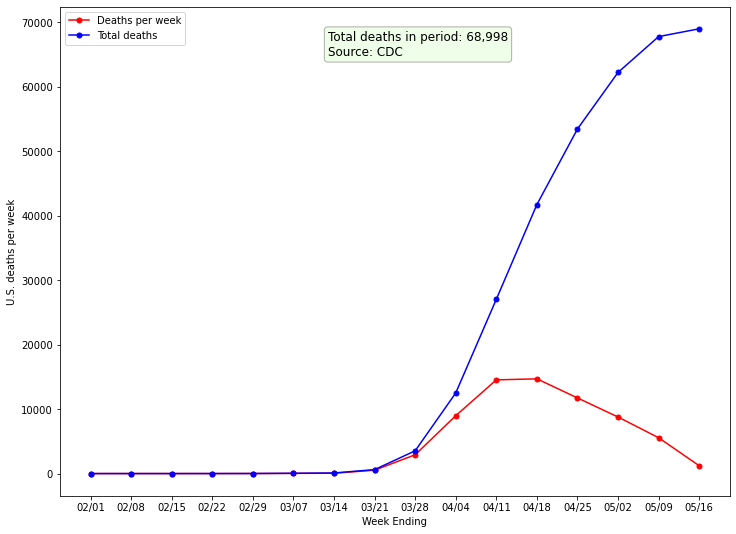

In [10]:
us_deaths = get_death_counts()
fig, ax = plot_deaths(us_deaths, 'U.S. deaths per week')
fig.show()

### Deaths per week, for a number of states

In [11]:
cdc_data = [(get_death_counts(state), state, color, line_style) 
            for state, (color, line_style) in zip(states, line_colors_and_styles)]

#### Some of the bigger-hit states

- California
- Connecticut
- Florida
- Georgia
- Illinois
- Massachusetts
- New York
- Ohio
- Pennsylvania
- Washington


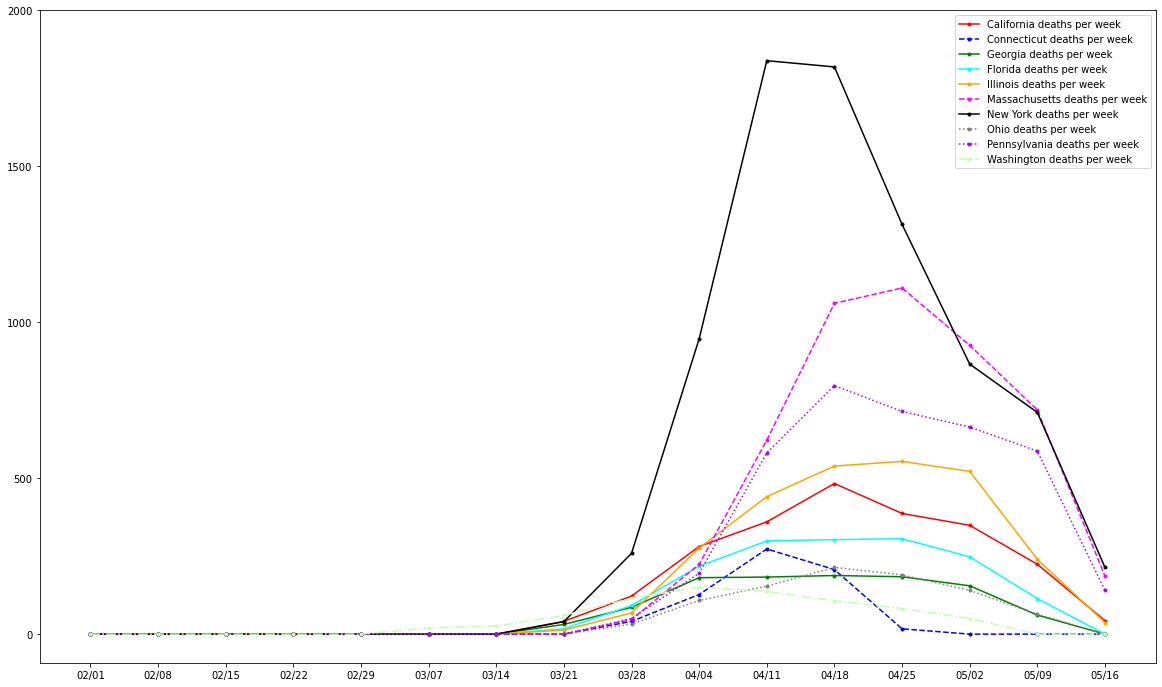

In [13]:
# Line graph

fig, ax = p.subplots(figsize=(20, 12))

max_deaths = 0
for stats, state, color, line_style, in cdc_data:
    deaths_per_week = [s[1] for s in stats]
    max_deaths = max(max(deaths_per_week), max_deaths)
    weeks = [datestr(s[0]) for s in stats]

    # Plot deaths per week.
    ax.plot(weeks, deaths_per_week, color=color, marker='.', linestyle=line_style,
           label=f'{state} deaths per week')

ymax, stride = determine_ymax_and_stride(max_deaths)
ax.set_yticks(range(0, ymax)[::stride])

ax.legend()

## Johns Hopkins data

### Read the data

In [17]:
from dataclasses import dataclass

@dataclass(frozen=True)
class JHUStateData:
    state: str
    deaths: int
    confirmed: int
    recovered: int
    tested: int
    mortality_rate: float

def read_jhu_data(path):
    """
    Read and load one JHU data file. Returns a dictionary indexed by full
    state name, with the statistics for that state represented in a JHUStateData
    object.
    """
    data_by_state = dict()
    with open(path, mode='r', encoding='UTF-8') as f:
        c = csv.DictReader(f)
        for row in c:
            state = row['Province_State']
            data_by_state[state] = JHUStateData(
                state=state,
                confirmed=csv_int_field(row, 'Confirmed'),
                deaths=csv_int_field(row, 'Deaths'),
                recovered=csv_int_field(row, 'Recovered'),
                tested=csv_int_field(row, 'People_Tested'),
                mortality_rate=csv_float_field(row, 'Mortality_Rate')
            )
    return data_by_state

def read_all():
    """
    Read all the data files in the appropriate JHU/CSSE directory. The data files
    are named after the date, in this format: 04-21-2020.csv. This function
    identifies all such files and reads them into a dictionary indexed by date.
    Each value in the dictionary is a another dictionary indexed by full state name
    and pointing to a JHUStateDate object.
    """
    jhu_data = dict()
    f_pat = re.compile(r'^([01]\d-[0123]\d-202\d)\.csv')
    for f in os.listdir(JOHNS_HOPKINS_DIR_PATH):
        m = f_pat.match(f)
        if m is None:
            continue
        date = datetime.strptime(m.group(1), '%m-%d-%Y').date()
        jhu_data[date] = read_jhu_data(os.path.join(JOHNS_HOPKINS_DIR_PATH, f))
    return jhu_data

In [18]:
jhu_data = read_all()
print(f"Read data for {len(jhu_data)} days.")
jhu_starting_date = min(jhu_data.keys())
jhu_ending_date = max(jhu_data.keys())
print(f"Starting date: {datestr(jhu_starting_date, include_year=True)}")
print(f"Ending date: {datestr(jhu_ending_date, include_year=True)}")

Read data for 38 days.
Starting date: 04/12/2020
Ending date: 05/19/2020


In [19]:
dates_in_order = sorted(jhu_data.keys())

### Deaths and recoveries across the US

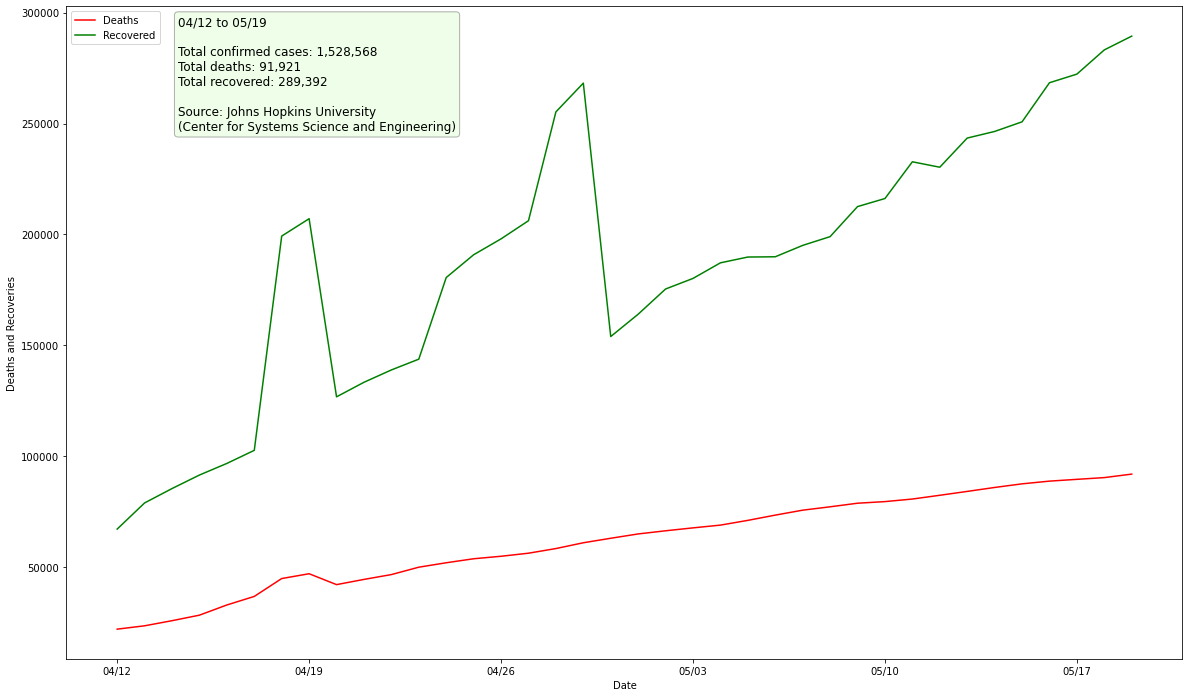

In [20]:
# Line chart plot of deaths and recoveries.

fig, ax = p.subplots(figsize=(20, 12))
x_dates = [datestr(d) for d in dates_in_order]
total_deaths = []
total_cases = []
total_recovered = []

for date in dates_in_order:
    data = jhu_data[date]
    total_deaths.append(sum([j.deaths for state, j in data.items()]))
    total_cases.append(sum([j.confirmed for state, j in data.items()]))
    total_recovered.append(sum([j.recovered for state, j in data.items()]))

ax.plot(x_dates, total_deaths, color='red', label='Deaths')
#ax.plot(x_dates, total_cases, color='blue', label='Confirmed Cases')
ax.plot(x_dates, total_recovered, color='green', label='Recovered')

ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days
ax.set_xlabel('Date')
ax.set_ylabel('Deaths and Recoveries')
ax.legend()
text = f"""{x_dates[0]} to {x_dates[-1]}

Total confirmed cases: {total_cases[-1]:,}
Total deaths: {total_deaths[-1]:,}
Total recovered: {total_recovered[-1]:,}

Source: Johns Hopkins University
(Center for Systems Science and Engineering)"""
textbox(ax, 0.1, 0.81, text)

### Individual States

In [33]:
def plot_state(state, color='red', fig=None, ax=None, image_file=None):
    if ax is None:
        fig, ax = p.subplots(figsize=(20, 12))

    x_dates = [datestr(d) for d in dates_in_order]
    total_deaths = []
    total_cases = []
    total_recovered = []

    for date in dates_in_order:
        data = jhu_data[date][state]
        total_deaths.append(data.deaths)
        total_cases.append(data.confirmed)
        total_recovered.append(data.recovered)

    ax.plot(x_dates, total_deaths, color=color, label='Deaths')
    #ax.plot(x_dates, total_cases, color='blue', label='Confirmed Cases')
    #if sum(total_recovered) > 0:
    #    ax.plot(x_dates, total_recovered, color='green', label='Recovered')

    ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days
    max_deaths = total_deaths[-1]
    ymax, stride = determine_ymax_and_stride(max_deaths)
    ax.set_yticks(range(0, ymax)[::stride])
    ax.set_xlabel('Date')
    ax.set_ylabel('Deaths, Confirmed Cases, Recoveries')
    ax.legend()
    final_total_recovered = total_recovered[-1]
    recovered_summary = f"{final_total_recovered:,}" if final_total_recovered > 0 else "No data on recovered cases"
    text = f"""{state}: {x_dates[0]} to {x_dates[-1]}

Total confirmed cases: {total_cases[-1]:,}
Total deaths: {max_deaths:,}
Total recovered: {recovered_summary}

Source: Johns Hopkins University
(Center for Systems Science and Engineering)"""
    textbox(ax, 0.01, 0.80, text)
    if image_file is not None:
        fig.savefig(os.path.join(IMAGES_PATH, image_file))
        
    return (fig, ax)

#### Pennsylvania

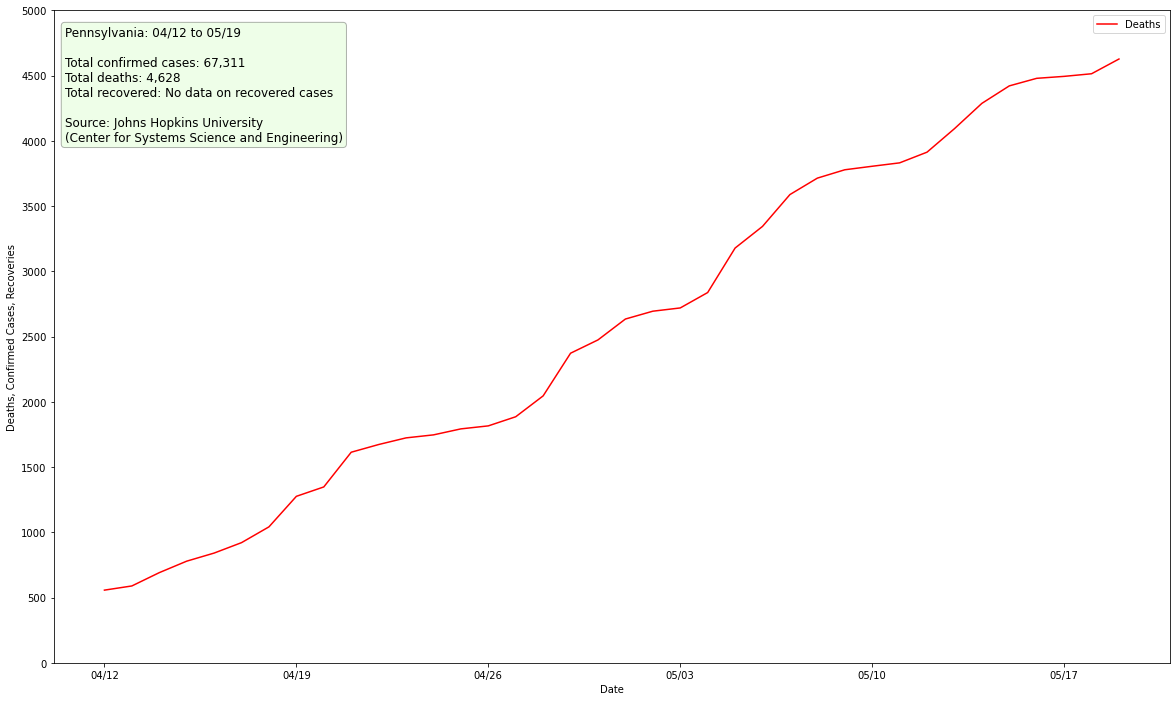

In [34]:
fig, ax = plot_state('Pennsylvania', image_file="pa.png")

#### New York

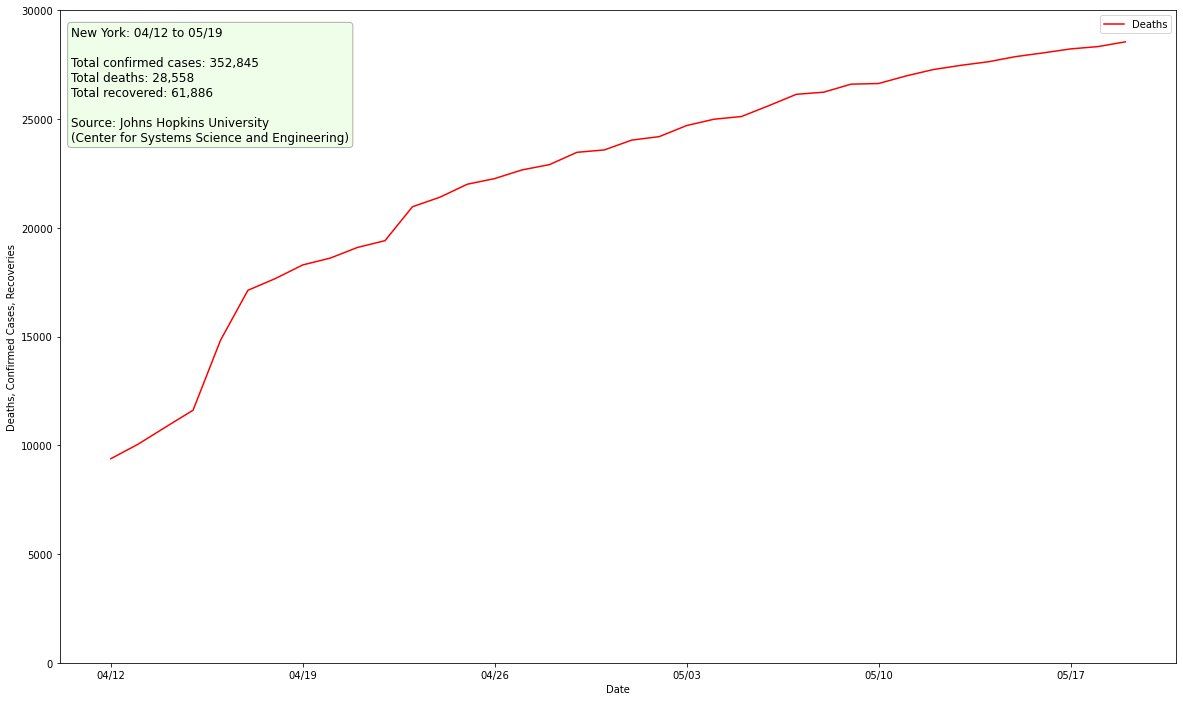

In [35]:
ax, fig = plot_state('New York', image_file="ny.png")

#### Washington

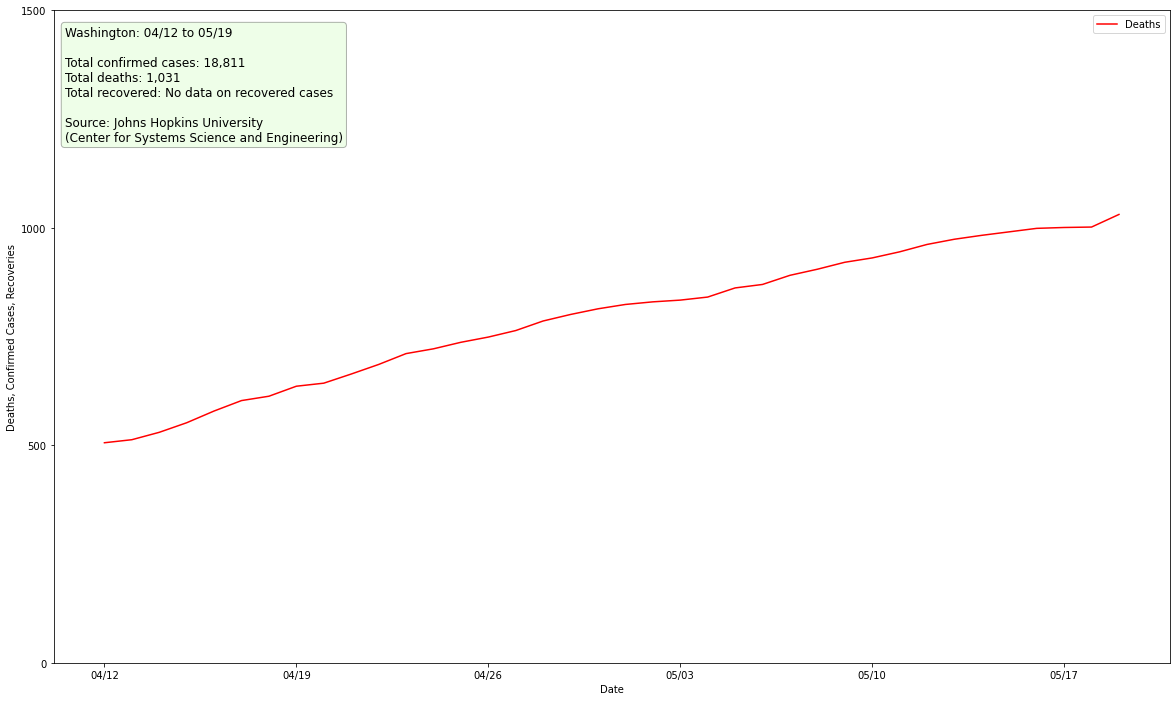

In [36]:
fig, ax = plot_state('Washington', image_file="wa.png")

#### Delaware

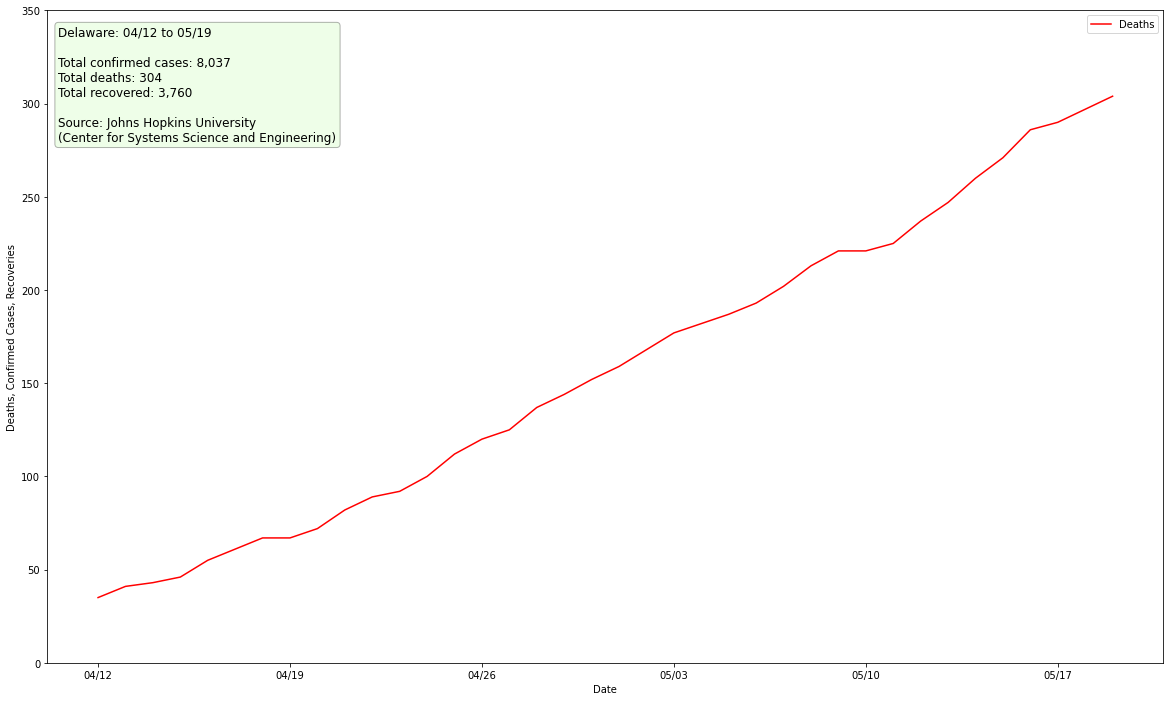

In [37]:
fig, ax = plot_state('Delaware', image_file='de.png')

### Multistate

In [39]:
def jhu_plot_states(jhu_data, states, text_x=0.12, text_y=0.69, image_file=None):
    fig, ax = p.subplots(figsize=(20, 11))

    total_deaths_by_state = dict()
    for state, (color, linestyle) in zip(states, line_colors_and_styles):
        x_dates = [datestr(d) for d in dates_in_order]
        total_deaths = []
        total_cases = []
        total_recovered = []

        for date in dates_in_order:
            data = jhu_data[date][state]
            total_deaths.append(data.deaths)
            total_cases.append(data.confirmed)
            total_recovered.append(data.recovered)

        ax.plot(x_dates, total_deaths, color=color, label=state, linestyle=linestyle)
        total_deaths_by_state[state] = total_deaths[-1]

    max_total_deaths = max(total_deaths_by_state.values())
    ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days
    ymax, stride = determine_ymax_and_stride(max_total_deaths)
    ax.set_yticks(range(0, ymax)[::stride])
    ax.set_xlabel('Date')
    ax.set_ylabel('Deaths, Confirmed Cases, Recoveries')
    ax.legend()

    text_lines = ["TOTAL DEATHS", ""]
    for state, count in sorted(total_deaths_by_state.items(), key=lambda v: v[1], reverse=True):
         text_lines.append(f"{state}: {count:,}")

    last_day = jhu_data[dates_in_order[-1]]
    total_deaths_in_us = sum([j.deaths for j in last_day.values()])

    text = '\n'.join(text_lines)
    textbox(ax, text_x, text_y, text)
    textbox(ax, 0.26, 0.97, f"Total US Deaths in Period: {total_deaths_in_us:,}", bg='xkcd:pale blue')
    if image_file is not None:
        fig.savefig(os.path.join(IMAGES_PATH, image_file))
    return fig, ax

#### Same set of states used in CDC plot, above

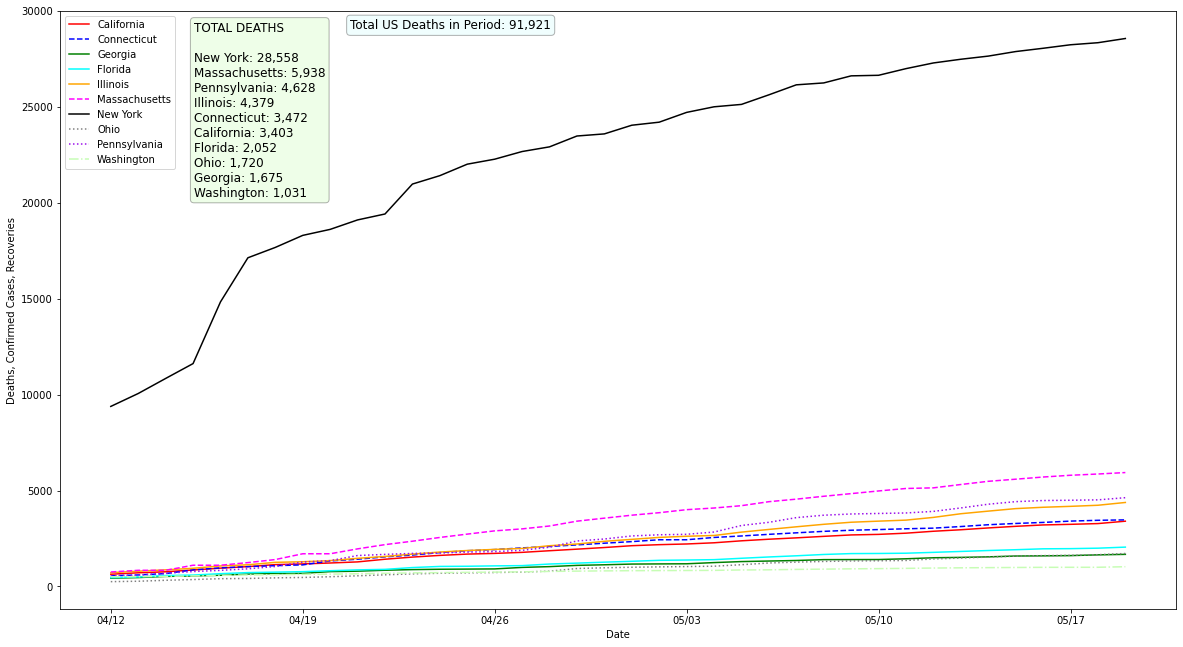

In [40]:
fig, ax = jhu_plot_states(jhu_data, states, image_file='states1.png')

#### Sames states, but without New York

New York, as a hotspot, skews the graph.

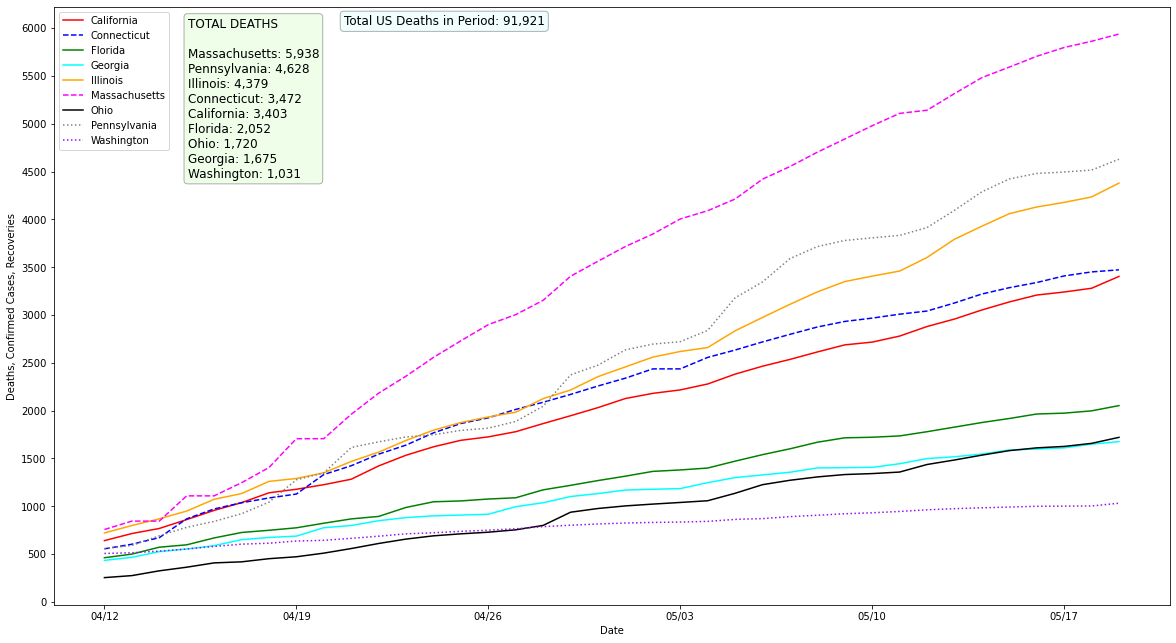

In [41]:
without_ny = sorted(list(set(states) ^ set(('New York',))))
fig, ax = jhu_plot_states(jhu_data, without_ny, text_y=0.715, image_file='states2.png')

### Just the past week

In [26]:
week_delta = timedelta(days=6)
six_days_prior = jhu_ending_date - week_delta
print(datestr(six_days_prior, include_year=True))
print(datestr(jhu_ending_date, include_year=True))

05/13/2020
05/19/2020


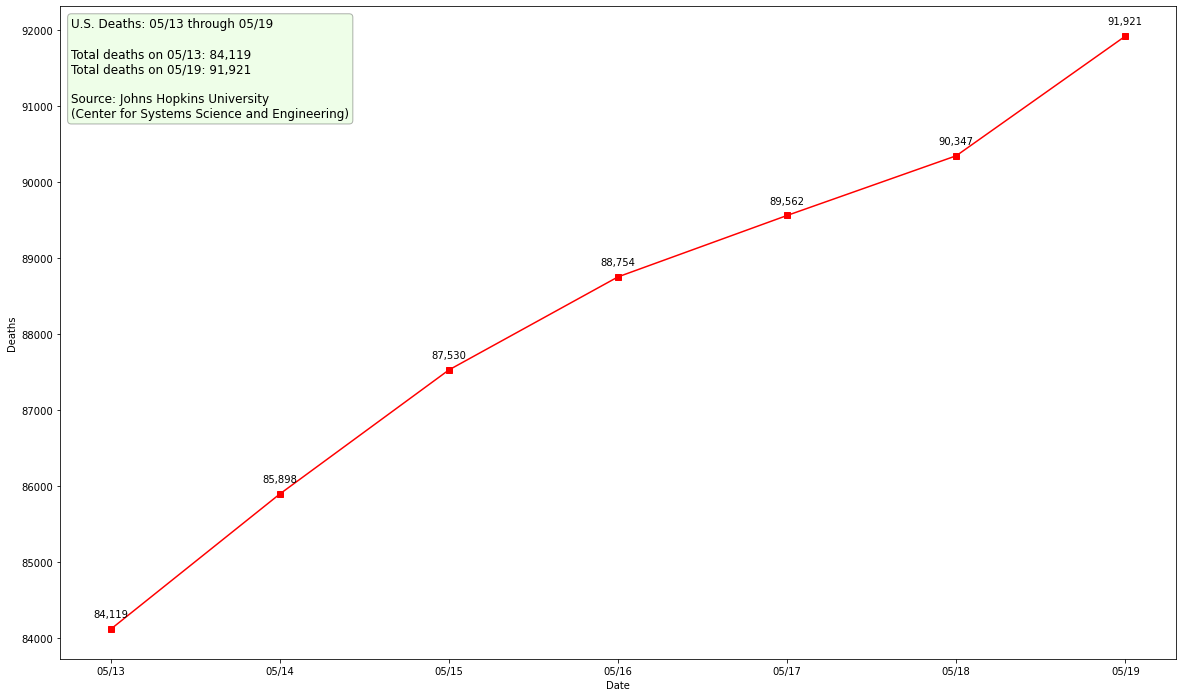

In [43]:
fig, ax = p.subplots(figsize=(20, 12))
x_dates = [datestr(d) for d in dates_in_order if d >= six_days_prior]
total_deaths = []
total_cases = []
total_recovered = []

for date in dates_in_order:
    if date < six_days_prior:
        continue
    data = jhu_data[date]
    total_deaths.append(sum([j.deaths for state, j in data.items()]))
    total_cases.append(sum([j.confirmed for state, j in data.items()]))
    total_recovered.append(sum([j.recovered for state, j in data.items()]))

ax.plot(x_dates, total_deaths, color='red', label='Deaths', marker='s')
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')

# Put the actual numbers on the chart.
for x, y in zip(x_dates, total_deaths):
    label = f"{y:,}"
    # The xytext values are absolute — and kind of fiddly.
    ax.annotate(label, (x, y), ha='center', xytext=(x, y+150))

text = f"""U.S. Deaths: {x_dates[0]} through {x_dates[-1]}

Total deaths on {x_dates[0]}: {total_deaths[0]:,}
Total deaths on {x_dates[-1]}: {total_deaths[-1]:,}

Source: Johns Hopkins University
(Center for Systems Science and Engineering)"""
textbox(ax, 0.01, 0.83, text)
fig.savefig(os.path.join(IMAGES_PATH, 'past-week.png'))

### Deaths vs. Confirmed Cases vs. People Tested

U.S. COVID-19: 04/12 through 05/19

Total deaths: 91,921
Total people recovered: 289,392
Total people tested: 12,233,987
Total confirmed cases: 1,528,568

Source: Johns Hopkins University
(Center for Systems Science and Engineering)


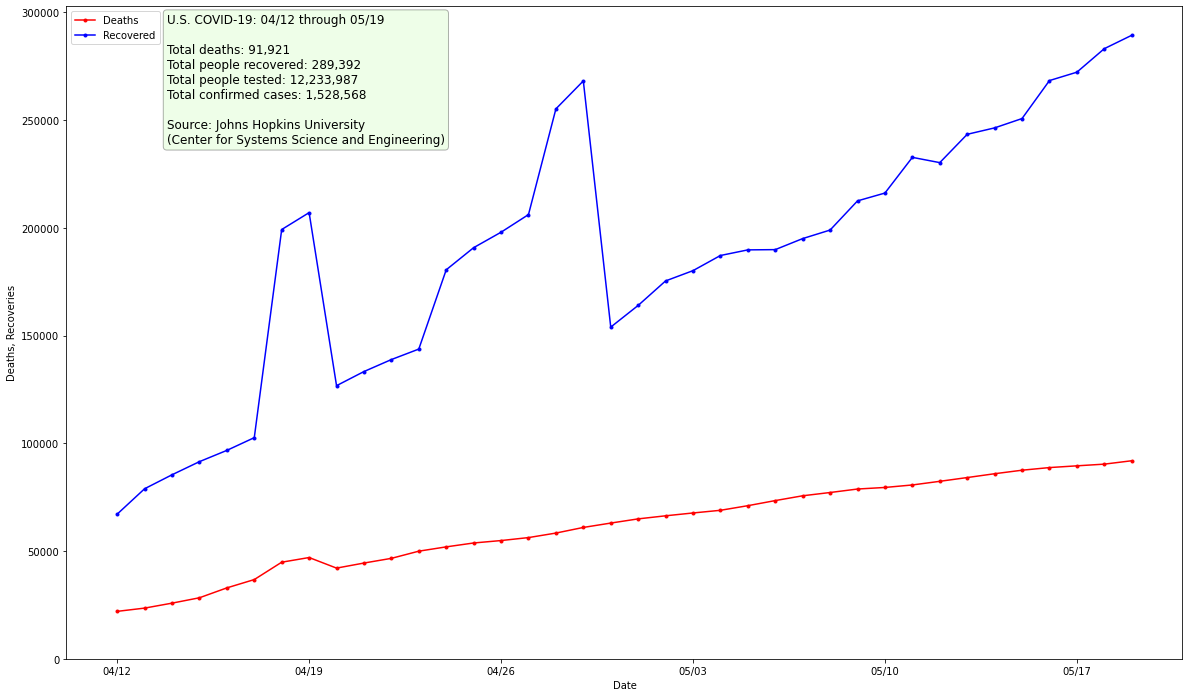

In [44]:
fig, ax = p.subplots(figsize=(20, 12))
x_dates = [datestr(d) for d in dates_in_order]
total_deaths = []
total_cases = []
total_tested = []
total_recovered = []

for date in dates_in_order:
    data = jhu_data[date]
    total_deaths.append(sum([j.deaths for state, j in data.items()]))
    total_cases.append(sum([j.confirmed for state, j in data.items()]))
    total_tested.append(sum([j.tested for state, j in data.items()]))
    total_recovered.append(sum([j.recovered for state, j in data.items()]))
    
ax.plot(x_dates, total_deaths, color='red', label='Deaths', marker='.')
ax.plot(x_dates, total_recovered, color='blue', label='Recovered', marker='.')
#ax.plot(x_dates, total_tested, color='green', label='Tested', marker='.')
#ax.plot(x_dates, total_cases, color='orange', label='All Cases', marker='.')
ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days

#max_number = max(total_deaths[-1], total_tested[-1], total_cases[-1], total_recovered[-1])
max_number = max(total_deaths[-1], total_recovered[-1])
ymax, stride = determine_ymax_and_stride(max_number)
ax.set_yticks(range(0, ymax)[::stride])
ax.set_xlabel('Date')
ax.set_ylabel('Deaths, Recoveries')

ax.legend()

text = f"""U.S. COVID-19: {x_dates[0]} through {x_dates[-1]}

Total deaths: {total_deaths[-1]:,}
Total people recovered: {total_recovered[-1]:,}
Total people tested: {total_tested[-1]:,}
Total confirmed cases: {total_cases[-1]:,}

Source: Johns Hopkins University
(Center for Systems Science and Engineering)"""
textbox(ax, 0.09, 0.79, text)
fig.savefig(os.path.join(IMAGES_PATH, 'deaths-recoveries.png'))
print(text)

### Mortality rates over time

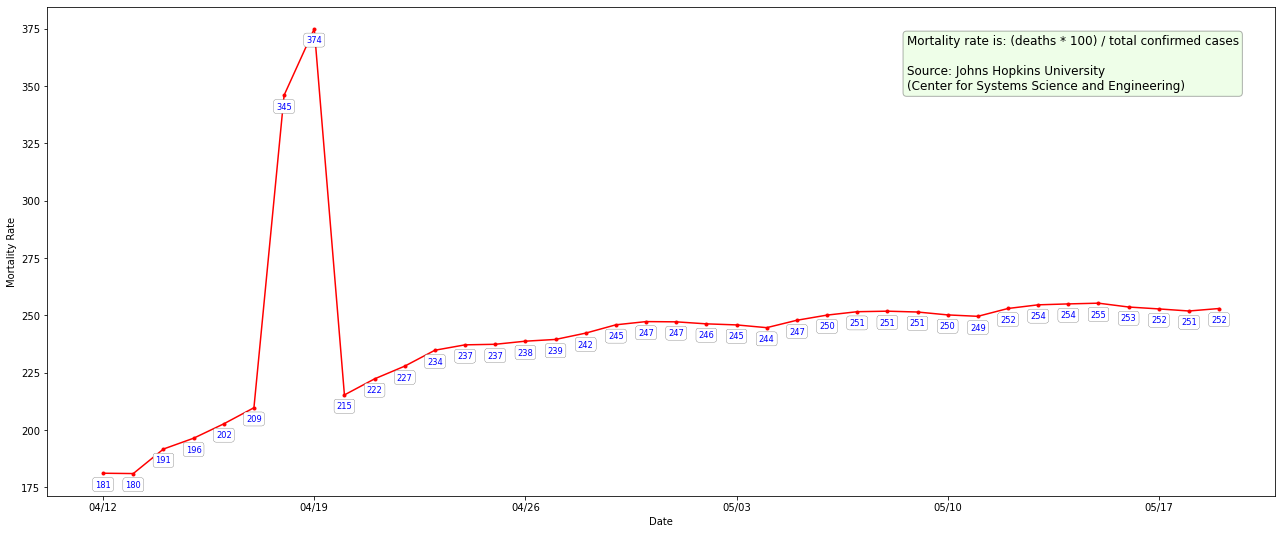

In [45]:
fig, ax = p.subplots(figsize=(22, 9))
x_dates = [datestr(d) for d in dates_in_order]
total_mortality_rate = []

for date in dates_in_order:
    data = jhu_data[date]
    total_mortality_rate.append(sum([j.mortality_rate for state, j in data.items()]))
    
ax.plot(x_dates, total_mortality_rate, color='red', label='Mortality Rate', marker='.')
ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days

#max_number = max(total_deaths[-1], total_tested[-1], total_cases[-1], total_recovered[-1])
#max_number = max(total_deaths[-1], total_recovered[-1])
#ymax, stride = determine_ymax_and_stride(max_number)
#ax.set_yticks(range(0, ymax)[::stride])
ax.set_xlabel('Date')
ax.set_ylabel('Mortality Rate')

x_coordinates = [i for i, _ in enumerate(x_dates)]
# Put the actual numbers on the chart.
for x, y in zip(x_coordinates, total_mortality_rate):
    label = f"{int(y):,}"
    # The xytext values are absolute — and kind of fiddly.
    box_props = {
        'boxstyle': 'round',
        'facecolor': 'white',
        'linewidth': 0.2,
        'alpha': 1.0,
    }
    ax.annotate(label, (x, int(y)), ha='center', xytext=(x, y-6),
                bbox=box_props, fontsize='small', color='blue')

#ax.legend()

text = f"""Mortality rate is: (deaths * 100) / total confirmed cases

Source: Johns Hopkins University
(Center for Systems Science and Engineering)"""
textbox(ax, 0.70, 0.83, text)
fig.savefig(os.path.join(IMAGES_PATH, 'mortality.png'))